## Estimating surface area from concave hull



Let's use some output from a Lagrangian particle tracking model called OpenDrift (https://opendrift.github.io/install.html) to estimate the area of a make-believe surface oil slick. You can find the dataset [here](https://github.com/vic1309/concave_hull_area). First things first, let's open it!


In [1]:
import netCDF4 as nc

path = r'/home/victor/Desktop/MET/projects/osmico/runs/hea/osmico_output/run_osmico_hea.nc'

df = nc.Dataset(path)

# define lat/lon 
lat = df.variables['lat'][:] 
lon = df.variables['lon'][:]


We ran 1000 virtual particles for 10 days with a time step of 1 hour. Hence, we have the hourly position of every particle from the *10/03/2019 12:00hrs* until the *20/03/2019 12:00hrs* 

In [3]:
lat.shape
lon.shape

(1000, 241)

Let's plot these particles to see their trajectories

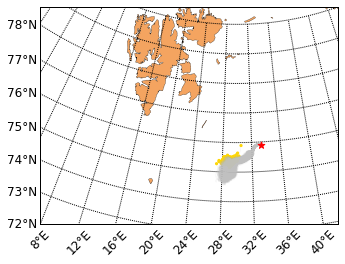

In [2]:
import matplotlib.pyplot as plt 
from mpl_toolkits.basemap import Basemap
import numpy as np

m = Basemap(projection='tmerc', llcrnrlon=8, llcrnrlat=72,
                urcrnrlon=50, urcrnrlat=80, resolution='h', lat_0 = 76, lon_0 = 30)

# draw coastlines, country boundaries, fill continents.
m.drawcoastlines(linewidth=0.25)
m.drawcountries(linewidth=0.25)
m.fillcontinents(color='sandybrown', lake_color='white')

# draw the edge of the map projection region (the projection limb)
m.drawmapboundary(fill_color='white')

# draw lat/lon grid lines every 30 degrees.
m.drawmeridians(np.arange(0,360,4),labels=[0,0,0,1], fontsize = 12, rotation = 45)
m.drawparallels(np.arange(-90,90,1),labels=[1,0,0,0], fontsize = 12)

# convert lon and lat to the map projection
x, y = m(lon, lat) 

# plot the location of the oil spill site
plt.scatter(x[0, 0], y[0, 0], marker='*', s=50, color='red', zorder=1e4)

# plot particles at the last time step
cs = plt.scatter(x[:,-1], y[:,-1], c='gold', s=10, marker='o', edgecolors='none', zorder=1e3)

alpha = 0.1
linewidth = 1
# plot the trajectories for the whole run
plt.plot(x.T, y.T, alpha=alpha, color='silver', linewidth = linewidth, zorder = 1e3);


We are in the Barents Sea, just south of Svalbard. We see that the cloud of particles drift in a cohesive fashion, almost entirely altogether. The next step is to apply a method which we can define a boundary, or a hull, around the particles. Let's start by using the **convex-hull** before the concave-hull and see what happens.

For a matter of visualization, I will left Basemap behind otherwise one won't be able to see the hulls in detail. I will use the [SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.ConvexHull.html) function. Moreover, we could make the hull for every time step and see how it evolves but let's play simple at first and check only the last time step. 

In [6]:
# Stack (lat, lon) into a single 2-D array

points = np.column_stack((lon[:, -1], lat[:, -1]))
points = np.array(points)

Now let's call the SciPy's convex-hull function and make a plot of that:

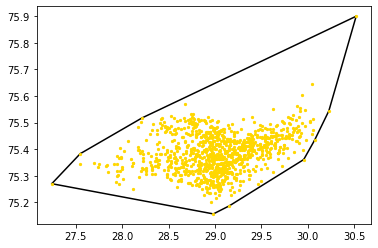

In [7]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d

# apply the conver-hull on our stacked (lat, lon) points
hull = ConvexHull(points)

# plot the particles
ck = plt.scatter(lon[:, -1], lat[:, -1], marker='o', zorder=1e3, s=5, color="gold")

# plot the "gift wrapping"
for simplex in hull.simplices:
    plt.plot(points[simplex,0], points[simplex,1], 'k-')

It did a fairly nice job, right? However, it is clear that the area generated contains blank spots where the ocean is not directly polluted by the particles and hence we could expect an overstimation of the contaminated region. 

Now, let's change to the **concave-hull**. Before you dive into the code, I *highly* recommend the reading of the following posts:

   1. [Kevin Dwyer in the HumanGeo](http://blog.thehumangeo.com/2014/05/12/drawing-boundaries-in-python/)
    
   2. [João Paulo Figueira in the Towards Data Science](https://towardsdatascience.com/the-concave-hull-c649795c0f0f)
   3. [Mark Ireland in the Safe Software webpage](https://www.safe.com/blog/2012/05/fmeevangelist105/)

I will use the code made available by [Kevin](https://gist.github.com/dwyerk/10561690) with a very small modificatiion.

In [4]:
from shapely.ops import cascaded_union, polygonize
from scipy.spatial import Delaunay
import math
import shapely.geometry as geometry
from descartes import PolygonPatch

def plot_polygon(polygon):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    margin = .3

    x_min, y_min, x_max, y_max = polygon.bounds

    ax.set_xlim([x_min-margin, x_max+margin])
    ax.set_ylim([y_min-margin, y_max+margin])
    patch = PolygonPatch(polygon, fc='#ffdede', ec='#ffdede', fill=True, zorder=-1)
    ax.add_patch(patch)
    return fig, patch

def alpha_shape(points, alpha, only_outer=True):
    """
    Compute the alpha shape (concave hull) of a set of points.

    @param points: Iterable container of points.
    @param alpha: alpha value to influence the gooeyness of the border. Smaller
                  numbers don't fall inward as much as larger numbers. Too large,
                  and you lose everything!
    """
    if len(points) < 4:
        # When you have a triangle, there is no sense in computing an alpha
        # shape.
        return geometry.MultiPoint(list(points)).convex_hull

    def add_edge(edges, edge_points, coords, i, j):
        """Add a line between the i-th and j-th points, if not in the list already"""
        if (i, j) in edges or (j, i) in edges:
            assert (j, i) in edges, "Can't go twice over same directed edge right?"
            if only_outer:
                # if both neighboring triangles are in shape, it's not a boundary edge
                edges.remove((j, i))
            return
        edges.add( (i, j) )
        edge_points.append(coords[ [i, j] ])

    coords = np.array([point for point in points])

    tri = Delaunay(coords)
    edges = set()
    edge_points = []
    # loop over triangles:
    # ia, ib, ic = indices of corner points of the triangle
    for ia, ib, ic in tri.vertices:
        pa = coords[ia]
        pb = coords[ib]
        pc = coords[ic]

        # Lengths of sides of triangle
        a = math.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
        b = math.sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2)
        c = math.sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2)

        # Semiperimeter of triangle
        s = (a + b + c)/2.0

        # Area of triangle by Heron's formula
        area = math.sqrt(s*(s-a)*(s-b)*(s-c))
        circum_r = a*b*c/(4.0*area)

        # Here's the radius filter.
        #print circum_r
        if circum_r < alpha:
            add_edge(edges, edge_points, coords, ia, ib)
            add_edge(edges, edge_points, coords, ib, ic)
            add_edge(edges, edge_points, coords, ic, ia)

    m = geometry.MultiLineString(edge_points)
    triangles = list(polygonize(m))
    return cascaded_union(triangles), edge_points


There is now a problem: what is the most suitable value for $\alpha$? Well, you can play around with the code but I will start with $\alpha$ = 0.2

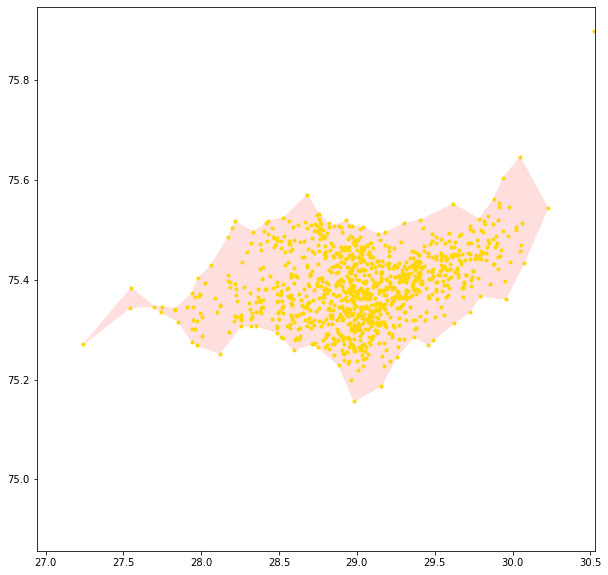

In [8]:
alpha = 0.2
concave_hull, edge_points = alpha_shape(points, alpha=alpha, only_outer=True)

# plot the hull and the particles
dr, patchs = plot_polygon(concave_hull)
_ = plt.plot(lon[:,-1], lat[:,-1], 'o', markersize=3, color='gold')



We see that the concave-hull wrapped the particles better than the convex-hull. But what about the particle in the top left corner? Changing $\alpha$ to 0.1:

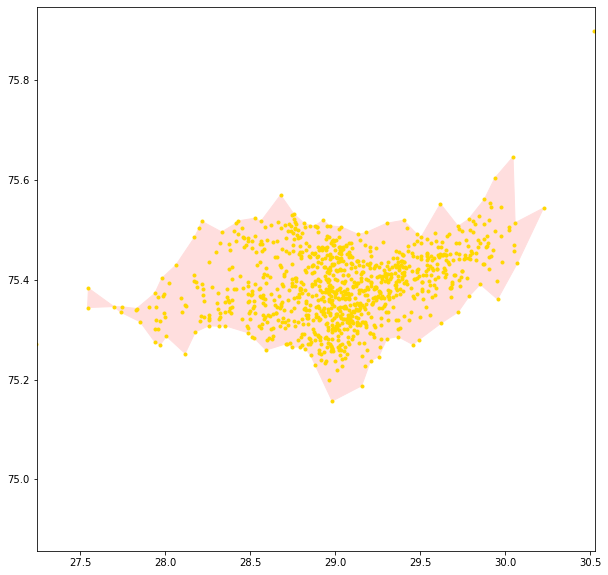

In [9]:
alpha = 0.1
concave_hull, edge_points = alpha_shape(points, alpha=alpha, only_outer=True)

dr, patchs = plot_polygon(concave_hull)
_ = plt.plot(lon[:,-1], lat[:,-1], 'o', markersize=3, color='gold')


Other particle, now the one in the bottom right corner, although not visible in this figure, wasn't considered in the triangulation and was left out. _**How to deal with that? Should I try clustering instead?**_

Problems aside, let's estimate the area of the latter case ($\alpha$ = 0.1). First, we must obtain the boundary coordinates, which are contained in the hull _Well Known Text_ (`.wkt`). Let's check this info.

In [10]:
concave_hull.wkt

'MULTIPOLYGON (((29.20967292785645 75.23800659179688, 29.15669822692871 75.18777465820312, 28.9831485748291 75.15708923339844, 28.88339614868164 75.229248046875, 28.85619354248047 75.24910736083984, 28.82415008544922 75.26200103759766, 28.7947940826416 75.26560211181641, 28.74818420410156 75.26533508300781, 28.7116870880127 75.2718505859375, 28.59395408630371 75.25932312011719, 28.52423667907715 75.28366851806641, 28.51450538635254 75.28642272949219, 28.48866081237793 75.29399871826172, 28.35132789611816 75.30839538574219, 28.31720733642578 75.30717468261719, 28.25718307495117 75.30799865722656, 28.17852020263672 75.29582977294922, 28.11842346191406 75.25248718261719, 28.00810813903809 75.28715515136719, 27.97054100036621 75.26922607421875, 27.93902206420898 75.27616882324219, 27.85319900512695 75.31610107421875, 27.7394847869873 75.33521270751953, 27.69889259338379 75.3465576171875, 27.74950408935547 75.34589385986328, 27.83365631103516 75.34268951416016, 27.9396800994873 75.373023986

We have two 'polygons' here and they are separated between themselves by the `,` and encapsulated by double brackets `(( ))`. In the figure you may see them as the small triangle-ish one on the left side and the big polygon occupying the rest.

We must separate them and as an initial step we will use the `LineString` function from `shapely.geometry`:

In [10]:
from shapely.geometry import LineString

rings = [LineString(pol.exterior.coords).wkt for pol in concave_hull]


In [15]:
rings

['LINESTRING (29.20967292785645 75.23800659179688, 29.15669822692871 75.18777465820312, 28.9831485748291 75.15708923339844, 28.88339614868164 75.229248046875, 28.85619354248047 75.24910736083984, 28.82415008544922 75.26200103759766, 28.7947940826416 75.26560211181641, 28.74818420410156 75.26533508300781, 28.7116870880127 75.2718505859375, 28.59395408630371 75.25932312011719, 28.52423667907715 75.28366851806641, 28.51450538635254 75.28642272949219, 28.48866081237793 75.29399871826172, 28.35132789611816 75.30839538574219, 28.31720733642578 75.30717468261719, 28.25718307495117 75.30799865722656, 28.17852020263672 75.29582977294922, 28.11842346191406 75.25248718261719, 28.00810813903809 75.28715515136719, 27.97054100036621 75.26922607421875, 27.93902206420898 75.27616882324219, 27.85319900512695 75.31610107421875, 27.7394847869873 75.33521270751953, 27.69889259338379 75.3465576171875, 27.74950408935547 75.34589385986328, 27.83365631103516 75.34268951416016, 27.9396800994873 75.373023986816

We see that they were splitted but are still _strings_, with (lat, lon) pairs as one single 'element' in the list.

My idea here was to loop over the list with the two polygons, remove the unnecessary things, split lat and lon into two different columns, project them on the Earth surface (`Pyproj`) and then, finally, estimate the area (`Shapely`). The estimation was provided by [sgillies](https://stackoverflow.com/questions/4681737/how-to-calculate-the-area-of-a-polygon-on-the-earths-surface-using-python?rq=1).

In [11]:
from pyproj import Proj
from shapely.geometry import shape

areas = []

for poly in rings:

    # split the rings into Y different elements in the list
    split_ring = [x.strip() for x in poly.split(',')]

    # store (lat, lon) boundary values to project it 
    # on the Earth surface and estimate the area  
    lon_b = [] 
    lat_b = []

    # loop over the 'splitted rings' to remove unnecessary 
    # things and save only the (lat, lon) values
    for i in range(0, len(split_ring)):
        if i == 0:
            spt = split_ring[i][12:].split(' ') 
            lon_b.append(float(spt[0]))
            lat_b.append(float(spt[1]))
        else:
            spt = split_ring[i].split(' ')

            if ')' in spt[1]:
                spt[1] = spt[1].replace(')', '') 
            lon_b.append(float(spt[0]))
            lat_b.append(float(spt[1]))

    
    # project the boundaries (lon_b, lat_b) using Pyproj 
    # with the same map projection as we used to plot the 
    # particles with Basemap 
    pa = Proj(proj='stere', lat_ts=55, lat_0=55, lon_0=50, ellps='WGS84')

    x, y = pa(lon_b, lat_b)
    cop = {"type": "Polygon", "coordinates": [zip(x, y)]}

    # use the 'shape' function from Shapely to estimate
    # the projected polygon area
    area_shape = shape(cop).area
    areas.append(area_shape)
    
print(lon_b, lat_b)

[27.54419136047363, 27.54911613464355, 27.69889259338379, 27.54419136047363] [75.34459686279297, 75.38343811035156, 75.3465576171875, 75.34459686279297]


In [28]:
areas # in m^2

[1724376086.6631217, 10217485.821230263]

In [29]:
[i/10**6 for i in areas] # in km^2

[1724.3760866631217, 10.217485821230262]

#### NOTE: 

For $\alpha$ = 0.2 one gets the following estimations:

`[1821.6763227505708, 29.660899705485168] # in km^2`

One can also use `Basemap`. Let's call our map again and estimate the area only for the small area (using the saved `[lon_b, lat_b]`). It uses the Green's Theorem and was provided by [Jason](https://stackoverflow.com/a/47951528/5091025)

In [30]:
xs, ys = m(lon_b, lat_b)
area_basemap = np.abs(0.5*np.sum(ys[:-1]*np.diff(xs)-xs[:-1]*np.diff(ys)))


In [31]:
area_basemap


9459086.876069427

### NOTE 2

The estimation for $\alpha$ = 0.2 using `Basemap` was _29.34971534709215_ [km$^{2}$] whereas for `Cartopy` + `Shapely` it was _29.660899705485168_ [km$^{2}$].


The last one is this nice code and numerical comparison between methods provided by [Yellows](https://stackoverflow.com/a/61184491/5091025).

In [32]:
def polygon_area(lats, lons, radius = 6378137):
    """
    Computes area of spherical polygon, assuming spherical Earth. 
    Returns result in ratio of the sphere's area if the radius is specified.
    Otherwise, in the units of provided radius.
    lats and lons are in degrees.
    """
    from numpy import arctan2, cos, sin, sqrt, pi, power, append, diff, deg2rad
    lats = np.deg2rad(lats)
    lons = np.deg2rad(lons)

    # Line integral based on Green's Theorem, assumes spherical Earth

    #close polygon
    if lats[0]!=lats[-1]:
        lats = append(lats, lats[0])
        lons = append(lons, lons[0])

    #colatitudes relative to (0,0)
    a = sin(lats/2)**2 + cos(lats)* sin(lons/2)**2
    colat = 2*arctan2( sqrt(a), sqrt(1-a) )

    #azimuths relative to (0,0)
    az = arctan2(cos(lats) * sin(lons), sin(lats)) % (2*pi)

    # Calculate diffs
    # daz = diff(az) % (2*pi)
    daz = diff(az)
    daz = (daz + pi) % (2 * pi) - pi

    deltas=diff(colat)/2
    colat=colat[0:-1]+deltas

    # Perform integral
    integrands = (1-cos(colat)) * daz

    # Integrate 
    area = abs(sum(integrands))/(4*pi)

    area = min(area,1-area)
    if radius is not None: #return in units of radius
        return area * 4*pi*radius**2
    else: #return in ratio of sphere total area
        return area

In [35]:
area_yellows = polygon_area(lat_b, lon_b)

print(area_yellows)

9403006.682264952


### NOTE 3

In my runs, I obtained the value of _27.29978108467238_ [km$^2$] using Yellows' approach for $\alpha$ = 0.2. So, summarizing: 

| alpha \ method |  sgillies [km$^{2}$] |   Jason [km$^{2}$]   |  Yellows [km$^{2}$]  |
|:--------------:|:--------------------:|:--------------------:|:--------------------:|
| $\alpha$ = 0.1 | [1724.3760, 10.2174] |  [1598.0832, 9.4590] |  [1588.7120, 9.4030] |
| $\alpha$ = 0.2 | [1821.6763, 29.6608] | [1688.2628, 27.4632] | [1678.3613, 27.2997] |

Where the _left_ values represent the area of the 'big' polygon and the right values the area of the 'small' polygon, both in km$^{2}$.

In average, the difference in the 'small' polygon area between the two different values of $\alpha$ was 18.5 km$^{2}$ whereas for the 'big' polygon the mean difference is 92.4 km$^{2}$

##### Which $\alpha$ value is the best one? Which method presents the best estimation?

### Question

#### Is it possible to use alpha 'operationally'? Is there a metrics which may define the "best" alpha value? What should we do with the points left outside of the hull?

PS: Estimate the area using the convex-hull